## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import os
import re
import sys
import time
import json
import glob
import pickle
import requests
import cv2

from PIL import Image
from copy import copy
from urllib.parse import quote as urlencode
import pprint
pp = pprint.PrettyPrinter(indent=4)

from ipywidgets import FileUpload
from IPython.display import display

import astropy
from astropy import units as u
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.modeling import models
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.coordinates import SkyCoord, Angle
from astropy.utils.data import download_file, get_pkg_data_filename
from astropy.visualization import make_lupton_rgb

import aplpy


from photutils.aperture import CircularAperture, SkyCircularAperture
from photutils.detection import DAOStarFinder

from regions import PixCoord, CirclePixelRegion, CircleSkyRegion

from specutils import Spectrum1D
from specutils import SpectrumList
from specutils.spectra import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_lines
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler

from scipy.optimize import curve_fit





from jdaviz import Imviz, Specviz, Cubeviz
from jdaviz.app import Application
imviz = Imviz()
specviz = Specviz()
cubeviz = Cubeviz()



## Imviz


#### To import JWST images
Find images as .fits files on https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

##### If you already downloaded the fits files, put them into fits directory.

#### Or alternatively, use MAST API to acquire them right here!
The code below when run in order will take a target identifier as input and request its coordinates from the MAST database.

Following this, all logged observations can be filtered by telescope/detector name and selected for download.

If you have already manually acquired your fits files you can place them in a directory entitled 'fits' in the same folder as this notebook and skip to the section labelled 'Loading Data'

### API Code
This cell defines the MAST query function for communicating with the MAST API

In [ ]:
#from https://mast.stsci.edu/api/v0/MastApiTutorial.html

def mast_query(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The MAST request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    # Base API url
    request_url='https://mast.stsci.edu/api/v0/invoke'    
    
    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    # Perform the HTTP request
    resp = requests.post(request_url, data="request="+req_string, headers=headers)
    
    # Pull out the headers and response content
    head = resp.headers
    content = resp.content.decode('utf-8')

    return head, content




Run this cell to enter target name and receive coordinates

In [ ]:
#returns RA, Dec from target identifier
object_of_interest = input('Object of Interest (eg. Messier Catalog designation etc): ')

resolver_request = {'service':'Mast.Name.Lookup',
                     'params':{'input':object_of_interest,
                               'format':'json'},
                     }

headers, resolved_object_string = mast_query(resolver_request)

resolved_object = json.loads(resolved_object_string)

print(resolved_object)

obj_type = resolved_object['resolvedCoordinate'][0]['objectType']
obj_ra = resolved_object['resolvedCoordinate'][0]['ra']
obj_dec = resolved_object['resolvedCoordinate'][0]['decl']

print('Object Type    : ',obj_type)
print('Right Ascension: ',obj_ra)
print('Declination    : ',obj_dec)


These next cells get the data for all observations of your selected target

In [ ]:
rownum = eval(input('Enter number of rows to return: '))

mast_request = {'service':'Mast.Caom.Cone',
                'params':{'ra':obj_ra,
                          'dec':obj_dec,
                          'radius':0.2},
                'format':'json',
                'pagesize':rownum,
                'page':1,
                'removenullcolumns':True,
                'removecache':True}

headers, mast_data_str = mast_query(mast_request)

mast_data = json.loads(mast_data_str)

pp.pprint(mast_data['data'][0])

In [ ]:
#Trying something here IGNORE THIS CELL

mashup_request = {"service":"Mast.JWST.Filtered.NIRCAM",
                 "format":"json",
                 "params":{
                     "columns":"*",
                     "filters":[
                         {"paramName":"ra",
                          "values":[obj_ra]
                         },
                         {"paramName":"dec",
                          "values":[obj_dec] 
                         }
                         
                     ]}}
    
headers, out_string = mast_query(mashup_request)
mast_data = json.loads(out_string)

print(mast_data.keys())
print("Query status:", mast_data['status'])

In [ ]:
mast_data_table = Table()

for col,atype in [(x['name'],x['type']) for x in mast_data['fields']]:
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    mast_data_table[col] = np.array([x.get(col,None) for x in mast_data['data']],dtype=atype)
    
print(mast_data_table)

Run the next cell to select instrument/telescope collection, then choose dataproducts you wish to prime for download. Bear in mind some JWST targets that have been observed may not have been made available to the public yet!

In [ ]:
inst = input('Choose instrument/collection (eg. HST, JWST): ')

interesting_observations = mast_data_table[mast_data_table["obs_collection"] == inst]


print(len(interesting_observations), "matching collection pieces found")
for i in range(0, len(interesting_observations)):
    print(i,":",[interesting_observations[i][x] for x in ['dataproduct_type', 'obs_collection', 'instrument_name','filters']])

if len(interesting_observations) > 0:
    selection = int(input("Please pick one: "))

The next cells retrieve your chosen dataproducts and provide a list of all files you can download.

In [ ]:


obsid = interesting_observations[selection]['obsid']

product_request = {'service':'Mast.Caom.Products',
                  'params':{'obsid':obsid},
                  'format':'json',
                  'pagesize':100,
                  'page':1}   

headers, obs_products_string = mast_query(product_request)

obs_products = json.loads(obs_products_string)

print("Number of data products:", len(obs_products["data"]))
#print("Product information column names:")
#pp.pprint(obs_products['fields'])

pp.pprint([x.get('productType',"") for x in obs_products["data"][:10]])



In [ ]:
sci_prod_arr = [x for x in obs_products['data'] if x.get("productType", None) == 'SCIENCE']
science_products = Table()

for col, atype in [(x['name'], x['type']) for x in obs_products['fields']]:
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    if atype == "int":
        atype = "float" # array may contain nan values, and they do not exist in numpy integer arrays
    science_products[col] = np.array([x.get(col,None) for x in sci_prod_arr],dtype=atype)

print("Number of science products:",len(science_products))
print(science_products)

Finally, you will be prompted on each product whether you want to download them or not. This helps screen out superfluous files like star catalog csvs if you do not wish to have them.

In [ ]:
download_url = 'https://mast.stsci.edu/api/v0.1/Download/file?'

for row in science_products:     
    print('Download',row['productFilename'],row['size']/1000000,'MB','? y/n')
    yn = input()
    if yn == 'y':
                
        # make file path
        out_path = os.path.join("fits", row['obs_collection'], row['obs_id'])
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        out_path = os.path.join(out_path, os.path.basename(row['productFilename']))
        
        if os.path.isfile(out_path):
            continue
        
        # Download the data
        payload = {"uri":row['dataURI']}
        resp = requests.get(download_url, params=payload)
    
        # save to file
        with open(out_path,'wb') as FLE:
            FLE.write(resp.content)
        
        # check for file 
        if not os.path.isfile(out_path):
            print("ERROR: " + out_path + " failed to download.")
        else:
            print("COMPLETE: ", out_path)
    
        

#### Loading Data
Run this cell to load JWST images into Imviz, the in-house software for processing post-pipeline JWST images. Can modify cuts factor here (percentage), generally the higher the better. The second cell can link the fits files by their WCS coords. Once the data is loaded you can run the third cell to open the Imviz GUI.

In [ ]:
all_fits = []

for DIR, ROOT, FILES in os.walk('fits'):
    for file in FILES:
        if file.endswith('.fits'):
            all_fits.append(os.path.join(DIR,file).replace('\\','/'))

print(all_fits)

In [ ]:
with imviz.batch_load():
    for file in all_fits:
        imviz.load_data(file)
        print(file,' loaded')
    print('All files loaded!')

#imviz.link_data(link_type='wcs')
viewer = imviz.default_viewer
viewer.cuts = '99%'
imviz.show()

In [ ]:
viewer = imviz.create_image_viewer('im2')

with imviz.batch_load():
    for file in all_fits:
        imviz.load_data(file, show_in_viewer='im2')
        print(file,' loaded')
    print('All files loaded!')

#imviz.link_data(link_type='wcs')


imviz.show()

In [ ]:
imviz.destroy_viewer('im2')


#### Processing Options



In [ ]:
print(viewer.colormap_options)
viewer.set_colormap('Inferno')

In [ ]:
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Read in the three images downloaded from here:
r_name = get_pkg_data_filename(input('Red channel: '))
g_name = get_pkg_data_filename(input('Green channel: '))
b_name = get_pkg_data_filename(input('Blue channel: '))
r = fits.open(r_name)[0].data
g = fits.open(g_name)[0].data
b = fits.open(b_name)[0].data

rgb_default = make_lupton_rgb(r, g, b, filename="output.jpeg")
plt.imshow(rgb_default, origin='lower')

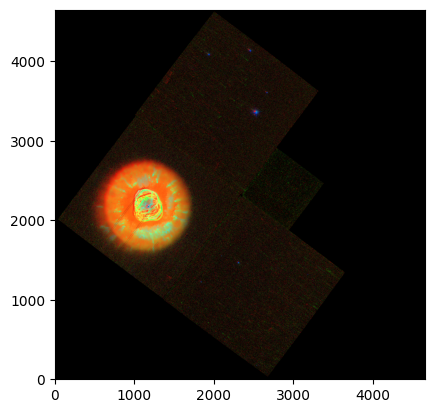

In [125]:
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Read in the three images downloaded from here:

reference_fits_file = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f502n_ua0105_drz.fits')


r_name = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f502n_ua0105_drz.fits')

g_name = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f656n_ua0105_drz.fits')

b_name = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f658n_ua0105_drz.fits')

#print(np.array(fits.open(r_name)[1].data))

#print(np.array(fits.open(reference_fits_file)[1].data))

r = np.array(fits.open(r_name)[1].data)
g = np.array(fits.open(g_name)[1].data)
b = np.array(fits.open(b_name)[1].data)



#print(fits.open(r_name)[1])

ref = np.array(fits.open(reference_fits_file)[1].data)




rgb_default = make_lupton_rgb(r, g, b, Q=10, stretch=0.005, filename="output.jpeg")
plt.imshow(rgb_default, origin='lower')

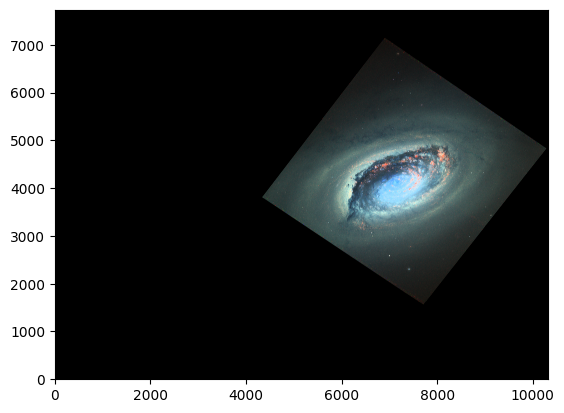

In [34]:
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Read in the three images downloaded from here:

reference_fits_file = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f502n_ua0105_drz.fits')


r_name = get_pkg_data_filename('fits/NGC4826/hst_skycell-p1809x06y10_wfc3_uvis_f336w_all_drc.fits')

g_name = get_pkg_data_filename('fits/NGC4826/hst_skycell-p1809x06y10_wfc3_uvis_f438w_all_drc.fits')

b_name = get_pkg_data_filename('fits/NGC4826/hst_skycell-p1809x06y10_wfc3_uvis_f555w_all_drc.fits')

#print(np.array(fits.open(r_name)[1].data))

#print(np.array(fits.open(reference_fits_file)[1].data))

r = np.array(fits.open(r_name)[1].data)
g = np.array(fits.open(g_name)[1].data)
b = np.array(fits.open(b_name)[1].data)



#print(fits.open(r_name)[1])

ref = np.array(fits.open(reference_fits_file)[1].data)




rgb_default = make_lupton_rgb(r*8.8, g*2.4, b*0.56, Q=0.1, stretch=0.5, filename="output.jpeg")
plt.imshow(rgb_default, origin='lower')

In [139]:
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Read in the three images downloaded from here:

reference_fits_file = get_pkg_data_filename('fits/hst_11122_05_wfpc2_pc_f502n_ua0105_drz.fits')


r_name = get_pkg_data_filename('fits/NGC160/rings.v3.skycell.1766.094.stk.i.unconv.fits')

g_name = get_pkg_data_filename('fits/NGC160/rings.v3.skycell.1766.094.stk.r.unconv.fits')

b_name = get_pkg_data_filename('fits/NGC160/rings.v3.skycell.1766.094.stk.g.unconv.fits')




print(fits.open(reference_fits_file).info())
print(fits.open(r_name).info())
print(fits.open(r_name)[1].columns)



r = np.array(fits.open(r_name)[1])
g = np.array(fits.open(g_name)[1])
b = np.array(fits.open(b_name)[1])

ref = np.array(fits.open(reference_fits_file)[1].data)

#print(fits.open(r_name).info())
#print(fits.open(reference_fits_file).info())

#print(r)

r_decomp = 

#r_raw = []

#for i in r:
#    r_raw.append(i[0])
#r_raw = np.array(r_raw)

#print(r_raw.shape)
#r_reshaped = np.reshape(np.array(r_raw), newshape=(6261,6279))








rgb_default = make_lupton_rgb(r, g, b, Q=10, stretch=0.5, filename="output.jpeg")
plt.imshow(rgb_default, origin='lower')

Filename: fits\hst_11122_05_wfpc2_pc_f502n_ua0105_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     909   ()      
  1  SCI           1 ImageHDU        95   (4660, 4649)   float32   
  2  WHT           1 ImageHDU        89   (4660, 4649)   float32   
  3  CTX           1 ImageHDU        92   (4660, 4649)   int32   
  4  HDRTAB        1 BinTableHDU    560   8R x 275C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, 8A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, 8A, 18A, D, D, D, D, D, D, 8A, D, 6A, 19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, D, D, D, D, D, D, D, D, D, 12A, 12A, 8A, 18A, D, D, 19A, 10A, D, D, D, 2A, D, 3A, D, D, 8A, D, K, D, 6A, 9A, D, D, D, 4A, 45A, 3A, K, D, D, D, D, 8A, D, D, D, D, D, 23A, 1A, D, 23A, D, D, D, 3A, L, D, 5A, 21A, D, 6A, D, D, D, D, D, D, D, D, D, D, D, L, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 8A, 8A, D, D, D, D, K, K, D, 1

ValueError: cannot convert float NaN to integer

In [11]:
type(r)

astropy.io.fits.hdu.hdulist.HDUList